In [153]:
import pandas as pd
import numpy as np
from random import *
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import warnings
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer, r2_score, mean_squared_error, auc, mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import linear_model

warnings.filterwarnings("ignore")

In [154]:
salaries = pd.read_csv("clean_kaggle_data_2022.csv", low_memory = False, encoding = 'latin2')
salaries.shape

(8137, 298)

In [155]:
salaries.head()

,Duration (in seconds),Q2,Q3,Q4,Q5,Q6_1,Q6_2,Q6_3,Q6_4,Q6_5,...,Q44_5,Q44_6,Q44_7,Q44_8,Q44_9,Q44_10,Q44_11,Q44_12,Q29_Encoded,Q29_buckets
0,Duration (in seconds),What is your age (# years)?,What is your gender? - Selected Choice,In which country do you currently reside?,"Are you currently a student? (high school, uni...",On which platforms have you begun or completed...,On which platforms have you begun or completed...,On which platforms have you begun or completed...,On which platforms have you begun or completed...,On which platforms have you begun or completed...,...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,NaN,NaN
1,851,55-59,Man,France,No,Coursera,NaN,Kaggle Learn Courses,NaN,NaN,...,"Course Forums (forums.fast.ai, Coursera forums...",NaN,NaN,"Blogs (Towards Data Science, Analytics Vidhya,...",NaN,NaN,NaN,NaN,2.0,"20,000-29,999"
2,501,30-34,Man,Germany,No,Coursera,edX,NaN,NaN,NaN,...,NaN,"YouTube (Kaggle YouTube, Cloud AI Adventures, ...",NaN,"Blogs (Towards Data Science, Analytics Vidhya,...",NaN,NaN,NaN,NaN,10.0,"100,000-124,999"
3,787,70+,Man,Australia,No,Coursera,NaN,Kaggle Learn Courses,NaN,NaN,...,NaN,NaN,"Podcasts (Chai Time Data Science, OEEReilly...",NaN,NaN,NaN,NaN,NaN,10.0,"100,000-124,999"
4,1132,40-44,Man,United States of America,No,Coursera,NaN,Kaggle Learn Courses,NaN,Fast.ai,...,NaN,NaN,"Podcasts (Chai Time Data Science, OEEReilly...","Blogs (Towards Data Science, Analytics Vidhya,...",NaN,NaN,NaN,NaN,13.0,"200,000-299,999"


In [156]:
null_list = salaries.isnull().sum(axis=0)

print(null_list[null_list > 2].sort_values())


Q30         50
Q16        684
Q12_1     1615
Q15_1     2895
Q9        2941
          ... 
Q20_5     8136
Q41_8     8136
Q39_11    8136
Q18_13    8136
Q35_15    8136
Length: 283, dtype: int64


# Question 1: Data Cleaning

- Drop the second row since it is about the question details
- Drop other information too if they are irrelevant to the task

In [157]:
def CleanData(df):
    # Drop the first row (question details)
    df.drop(df.index[0], inplace=True)
    df.drop(columns = ['Q29','Duration (in seconds)'], inplace=True)
    df = df.dropna(subset = ['Q30']) # Directly drop null val on Q30 
    df.dropna(axis=0, thresh= df.shape[1]*0.1, subset=None, inplace=True) # Drop the row that have more than 10% null response

    #TODO: Drop other information too here if they are irrelevant to the task

    return df

salaries = CleanData(salaries)
salaries.shape

(6680, 296)

###**Impute missing values (single column responses)**

1. Identify columns with single column responses

2. Address missing values in those columns

In [158]:
def ImputingSingleColMissingValues(df):
    # Tips: Include Q29_Encoded (target) in the single_col_names
    # so that its row size stays same as other rows after data preprocessing
    single_col_names = [col for col in df.columns if '_' not in col]#TODO: extract single column names and store them as a list
    single_col_names.append('Q29_Encoded')

    print("Percentage of null values: ")
    print(df[single_col_names].isnull().sum()*100/len(df))


    #TODO: address missing values in single column responses in df

    df['Q16'].fillna(df['Q16'].mode()[0],inplace=True) # Fill Null with mode (low %)
    df[['Q9', 'Q22', 'Q32', 'Q43']] = df[['Q9', 'Q22', 'Q32', 'Q43']].fillna("Unknown")# Fill Null with Unknow (High %)

    print("\nPercentage of null values (make sure they are all zeros): ")
    print(df[single_col_names].isnull().sum()*100/len(df))
    assert df[single_col_names].isnull().values.sum() == 0, \
        "There are still missing values remaining!"

    return df

salaries = ImputingSingleColMissingValues(salaries)
salaries.shape

Percentage of null values: 
Q2              0.000000
Q3              0.000000
Q4              0.000000
Q5              0.000000
Q8              0.000000
Q9             32.095808
Q11             0.000000
Q16             0.044910
Q22            76.032934
Q23             0.000000
Q24             0.000000
Q25             0.000000
Q26             0.000000
Q27             0.000000
Q30             0.000000
Q32            72.200599
Q43            34.131737
Q29_Encoded     0.000000
dtype: float64

Percentage of null values (make sure they are all zeros): 
Q2             0.0
Q3             0.0
Q4             0.0
Q5             0.0
Q8             0.0
Q9             0.0
Q11            0.0
Q16            0.0
Q22            0.0
Q23            0.0
Q24            0.0
Q25            0.0
Q26            0.0
Q27            0.0
Q30            0.0
Q32            0.0
Q43            0.0
Q29_Encoded    0.0
dtype: float64


(6680, 296)

###**Encode categorical features (sinlge column responses)**

In [159]:
#TODO: Encode categorical features in the single column responses
single_col_names = [col for col in salaries.columns if '_' not in col]
single_col_names.insert(0,'Q29_buckets')
single_col_names.insert(0,'Q29_Encoded')

multi_col_names = [col for col in salaries.columns if col not in single_col_names]
single_col_names_clean = single_col_names[2:] # Exclude Q29 Encoded and bucket

label_encoder = LabelEncoder()
for col in single_col_names_clean:
    salaries[col] = label_encoder.fit_transform(salaries[col])
salaries.shape

(6680, 296)

###**Handling categorical features (multi column responses)**

In [160]:
multi_col_names = multi_col_names #TODO: Identify multi-column responses
salaries = salaries.fillna('Not Select')

for col in multi_col_names:
  salaries[col] = salaries[col].apply(lambda x: 1 if x != 'Not Select' else 0)

print("Percentage of null values: ")
print(salaries[multi_col_names].isnull().sum()*100/len(salaries))

#TODO: Address missing values in the multi-column responses and and perform encoding for categorical features

salaries.shape


Percentage of null values: 
Q6_1      0.0
Q6_2      0.0
Q6_3      0.0
Q6_4      0.0
Q6_5      0.0
         ... 
Q44_8     0.0
Q44_9     0.0
Q44_10    0.0
Q44_11    0.0
Q44_12    0.0
Length: 277, dtype: float64


(6680, 296)

In [161]:
drop_col = []
muti_col =[]

for col in multi_col_names:
  work = col[:col.index('_')]

  if work not in salaries.columns:
    #print('Set up', work)
    salaries[work] = salaries[col]
    drop_col.append(col)
    muti_col.append(work)

  else:
    #print('Merge',col)
    salaries[work] = salaries[work]+ salaries[col]
    drop_col.append(col)

salaries.drop(columns = drop_col , inplace = True)


salaries.shape

(6680, 44)

In [162]:
salaries.head()

,Q2,Q3,Q4,Q5,Q8,Q9,Q11,Q16,Q22,Q23,...,Q34,Q35,Q36,Q37,Q38,Q39,Q40,Q41,Q42,Q44
1,8,0,15,0,6,1,1,0,1,4,...,0,1,0,1,1,1,2,0,1,4
2,3,0,16,0,0,1,1,4,1,11,...,0,0,0,0,0,0,0,0,0,5
3,10,0,2,0,1,2,2,5,9,10,...,1,0,0,1,1,0,1,0,0,2
4,5,0,55,0,1,2,1,5,9,5,...,2,3,2,1,1,1,2,0,1,4
5,5,0,55,0,3,2,1,5,9,4,...,2,5,3,2,1,1,2,0,2,3


###**Drop the target variable(s) and get the target variable**

In [163]:
# Make sure there are no missing values remaining in the dataset
assert salaries.isnull().values.sum() == 0, \
    "There are still {} missing values remaining in salaries!".format(salaries.isnull().values.sum())

In [164]:
target = salaries['Q29_Encoded']#TODO: get the target variable


#TODO: Drop the target variables from the feature set
col_to_drop = ['Q29_Encoded','Q29_buckets']
salaries.drop(columns = col_to_drop, inplace = True )

# Make sure the target variables are not included in the feature set
for col in salaries.columns:
    assert 'Q29' not in col, \
        "Target variable ({}) is still in the dataset".format(col)

In [165]:
salaries.head()

,Q2,Q3,Q4,Q5,Q8,Q9,Q11,Q16,Q22,Q23,...,Q34,Q35,Q36,Q37,Q38,Q39,Q40,Q41,Q42,Q44
1,8,0,15,0,6,1,1,0,1,4,...,0,1,0,1,1,1,2,0,1,4
2,3,0,16,0,0,1,1,4,1,11,...,0,0,0,0,0,0,0,0,0,5
3,10,0,2,0,1,2,2,5,9,10,...,1,0,0,1,1,0,1,0,0,2
4,5,0,55,0,1,2,1,5,9,5,...,2,3,2,1,1,1,2,0,1,4
5,5,0,55,0,3,2,1,5,9,4,...,2,5,3,2,1,1,2,0,2,3


# Question 2: Exploratory Feature Analysis

- From Question 2 - Question 4, you should **NOT** peek at the test labels in any form!
- Assume that you do not know the target values (Q29_Encoded)

## Split data into training and test sets

In [166]:
# You can use from sklearn.model_selection.train_test_split()
train_df, test_df, y_train, y_test = train_test_split(
                                        salaries,
                                        target,
                                        test_size=0.2,
                                        random_state=2024
                                        ) #TODO

## **Feature Engineering/Generation (Optional)**

- Create new feature(s) using existing features!

In [167]:
#TODO: Create new features (feature generation)

## **Feature Selection**

- Select the features based on the criteria of your choice

R² score: 0.33346102255067234


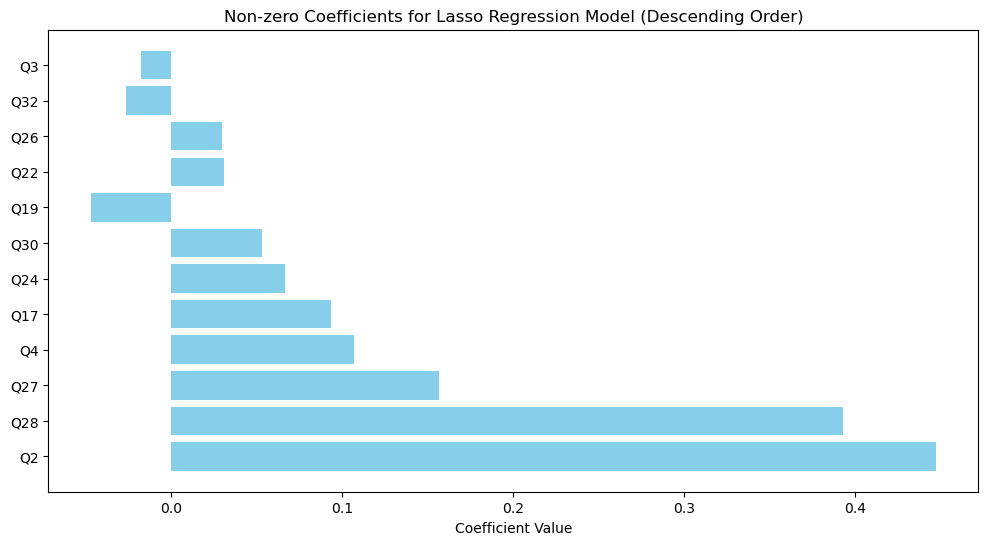

In [168]:
# Initialize and fit the LASSO model
reg = linear_model.Lasso(alpha=0.3, max_iter=10000)
reg.fit(train_df, y_train)

# Evaluate the model
r2_score = reg.score(train_df, y_train)
print("R² score:", r2_score)

coefficients = pd.Series(reg.coef_, index=train_df.columns)

# Select non-zero coefficients and their corresponding features
non_zero_features = coefficients[coefficients != 0]

# Sort non-zero features and coefficients in descending order
sorted_indices = np.argsort(np.abs(non_zero_features))[::-1]
sorted_feature_names = non_zero_features.index[sorted_indices]
sorted_coefficients = non_zero_features.values[sorted_indices]

# Plot the non-zero coefficients as a bar diagram
plt.figure(figsize=(12, 6))
plt.barh(sorted_feature_names, sorted_coefficients, align='center', color='skyblue')
plt.xlabel('Coefficient Value')
plt.title('Non-zero Coefficients for Lasso Regression Model (Descending Order)')
plt.show()


In [169]:
train_df_selected = train_df[sorted_feature_names]

## **Visualization**

- Make visualization to better understand your data

## **Apply the same feature engineering/selection to test data**

In [170]:
#TODO: Feature generation code you applied to the training data (optional)

# Leave selected features
test_df_selected = test_df[sorted_feature_names]

In [171]:
X_train = train_df_selected.values
X_test = test_df_selected.values
y_train = y_train.values
y_test = y_test.values

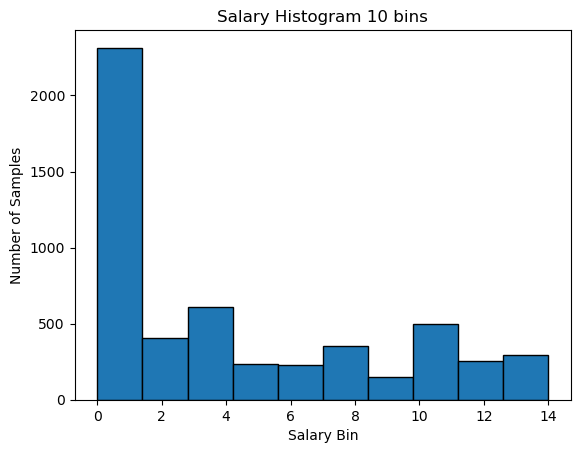

In [172]:
plt.hist(y_train, bins=10, edgecolor='black')
plt.title("Salary Histogram 10 bins")
plt.xlabel("Salary Bin")
plt.ylabel("Number of Samples")
plt.show()

# Question 3: Model Implementation

## Implement Ordinal Logistic Regression Model

In [173]:
from sklearn.linear_model import LogisticRegression
import numpy as np

class OrdinalLogisticRegression():
    # TODO: Add ordinal logreg hyperparameters as args to __init__
    # A dummy hyperparameter is put as a placeholder for now
    def __init__(self, max_iter=200, C=0.1):  # Updated placeholder for C
        # TODO: Add the ordinal logreg hyperparameters here
        self.max_iter = max_iter
        self.C = C  # Use the provided C hyperparameter

        self.classes_ = []
        self.models_ = []

    def fit(self, X, y):
        self.classes_ = sorted(np.unique(y))
        self.models_ = []

        # Train k-1 binary logistic regression models
        for i, c in enumerate(self.classes_[:-1]):  # We need only k-1 classifiers
            # TODO: label is 0 if the salary bucket is 0 to c, otherwise label is 1
            y_i = np.where(y <= c, 0, 1)
            # TODO: Use Logistic Regression as the binary logistic regression model
            model = LogisticRegression(max_iter=self.max_iter, C=self.C)  # Use the provided C hyperparameter
            model.fit(X, y_i)
            self.models_.append(model)

        # Store coefficients for feature importance
        self.coef_ = np.concatenate([model.coef_ for model in self.models_], axis=0)

        return self

    def predict_proba(self, X):
        assert len(self.models_) > 0, "Model is not fitted yet. Run .fit() first."

        # Predicted probabilities for k-1 binary logistic regression models (initialize placeholders)
        binary_probabilities = np.empty((X.shape[0], len(self.models_), 2), dtype=float)

        # Make predictions of k-1 binary logistic regression models
        for i, model in enumerate(self.models_):
            # TODO: predicted **probabilities** by the ith binary logistic regression model
            binary_probabilities[:, i] = model.predict_proba(X)

        # Compute the probabilities to be in each class
        k = len(self.classes_)
        proba = np.empty((X.shape[0], k), dtype=float)  # predicted probabilities for all the data in X (shape=(X.shape[0], k))

        proba[:, 0] = binary_probabilities[:, 0, 0]  # 0th probability

        for i in range(1, k - 1):
            # ith probability
            # (prob of belonging to class 0 for the ith model - prob of belonging to class 0 for the (i-1)th model
            proba[:, i] = binary_probabilities[:, i, 0] - binary_probabilities[:, i - 1, 0]

        proba[:, -1] = binary_probabilities[:, k - 2, 1]  # (k-1)th probability

        assert (proba.sum(axis=1) == 1).all(), \
            'There is a problem in the probability computation'
        return proba

    def predict(self, X):
        proba = self.predict_proba(X)
        return np.argmax(proba, axis=1)

    # Add hyperparameters here whenever you add new ones
    # max_iter is added as an example here. key is the hyperparameter name,
    # and value is the attribute name you defined in this class
    def get_params(self, deep=True):
        return {'max_iter': self.max_iter, 'C': self.C}

    # DO NOT CHANGE
    def set_params(self, **parameters):
        # Set estimator parameters
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self


## Run k-fold cross validation

- Report the average/variance of accuracies across folds

In [174]:
def run_k_fold(model, X, y, num_folds=5):
    """
    model          : scikit-learn-like models
    X (array-like) : Set of features
    y (array-like) : Set of target lables
    num_folds (int): the number of folds for cross-validation

    """

    # Initialize KFold cross-validator
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=0)

    accuracys = []

    # Iterate through the folds
    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = X[train_index], X[val_index]
        y_train_fold, y_val_fold = y[train_index], y[val_index]

        # Fit the model
        model.fit(X_train_fold, y_train_fold)

        # Predict on the validation set
        y_pred = model.predict(X_val_fold)
        #print("Unique values in y_pred:", np.unique(y_pred))

        # Calculate r2_score for this fold
        accuracy = accuracy_score(y_val_fold, y_pred)
        accuracys.append(accuracy)

    print("Average Accuracy    : ", np.mean(accuracys))
    print("Variance of Accuracy: ", np.var(accuracys))

In [175]:
print(X_train.shape,y_train.shape)

(5344, 12) (5344,)


In [176]:
model = OrdinalLogisticRegression()
run_k_fold(model, X_train, y_train , num_folds = 10)

predictions = model.predict(X_train)
test_accuracy = accuracy_score(y_train, predictions)

print("------------------\n Test Accuracy: {:.2%}".format(test_accuracy))

Average Accuracy    :  0.349734677447583
Variance of Accuracy:  0.000282722970284775
------------------
 Test Accuracy: 35.39%


## Bias-variance trade-off

[bias_variance_decomp.py](https://github.com/rasbt/mlxtend/blob/master/mlxtend/evaluate/bias_variance_decomp.py)

Below is a function you can use to compute the bias and variance of your ordinal logistic regression model. Using this function, analyze the ordinal logistic regression model performance based on bias-variance trade-off.

In [177]:
def _draw_bootstrap_sample(rng, X, y):
    sample_indices = np.arange(X.shape[0])
    bootstrap_indices = rng.choice(
        sample_indices, size=sample_indices.shape[0], replace=True
    )
    return X[bootstrap_indices], y[bootstrap_indices]

def bias_variance_decomp(
    estimator,
    X_train,
    y_train,
    X_test,
    y_test,
    num_rounds=10,
    random_seed=0
):
    """
    estimator : object
        A classifier or regressor object or class implementing both a
        `fit` and `predict` method similar to the scikit-learn API.

    X_train : array-like, shape=(num_examples, num_features)
        A training dataset for drawing the bootstrap samples to carry
        out the bias-variance decomposition.

    y_train : array-like, shape=(num_examples)
        Targets (class labels, continuous values in case of regression)
        associated with the `X_train` examples.

    X_test : array-like, shape=(num_examples, num_features)
        The test dataset for computing the average loss, bias,
        and variance.

    y_test : array-like, shape=(num_examples)
        Targets (class labels, continuous values in case of regression)
        associated with the `X_test` examples.

    num_rounds : int (default=10)
        Number of bootstrap rounds (sampling from the training set)
        for performing the bias-variance decomposition. Each bootstrap
        sample has the same size as the original training set.

    random_seed : int (default=0)
        Random seed for the bootstrap sampling used for the
        bias-variance decomposition.

    Returns
    ----------
    avg_bias, avg_var : returns the average bias, and average bias (all floats),
                        where the average is computed over the data points
                        in the test set.

    """
    loss = "mse"

    for ary in (X_train, y_train, X_test, y_test):
        assert type(ary) == np.ndarray, \
            "X_train, y_train, X_test, y_test have to be NumPy array. \
            If e.g., X_train is a pandas DataFrame, convert it to NumPy array \
            via X_train=X_train.values."

    rng = np.random.RandomState(random_seed)

    # All the predictions across different rounds
    all_pred = np.zeros((num_rounds, y_test.shape[0]), dtype=np.float64)

    for i in range(num_rounds):
        # Randomly sample training data
        X_boot, y_boot = _draw_bootstrap_sample(rng, X_train, y_train)

        # Fit the model using the randomly sampled data
        pred = estimator.fit(X_boot, y_boot).predict(X_test)
        all_pred[i] = pred

    # Mean prediction across runs using different dataset for each data point
    main_predictions = np.mean(all_pred, axis=0)

    # Average bias across different rounds
    avg_bias = np.sum((main_predictions - y_test) ** 2) / y_test.size

    # Average variance across different rounds
    avg_var = np.sum((main_predictions - all_pred) ** 2) / all_pred.size

    return avg_bias, avg_var

In [178]:
# Usage example
model = OrdinalLogisticRegression()
avg_bias, avg_var = \
    bias_variance_decomp(model, X_train, y_train, X_test, y_test, num_rounds=10, random_seed=0)

In [179]:
print(avg_bias, avg_var)

22.245733532934132 1.6693862275449103


In [180]:
#TODO: Discuss bias-variance trade-off of your ordinal logistic regression model

# Question 4: Model Tuning

- What are the hyperparameters we can potentially set for our ordinal logistic regression model?
- Which hyperparameters seem to be worthwhile to tune?

## Grid Search

- Grid search will take time to complete - but if it does not finish in a few hours, you're probably trying too many combinations
- A recommended approach is to try a small number of combinations with a wide range first (for continuous value hyperparameters)! Then gradually increase the points that seem to be near optimal

In [181]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score, mean_squared_error

#TODO: Perform grid search using a proper criteria and identify the best parameter set
param_grid = {
    'C': [0.001, 0.01, 0.1, 1],
    'max_iter': [100, 200, 300, 400, 500]
}

# Define the scoring function you want to optimize for
scorer = make_scorer('mean_squared_error')

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=OrdinalLogisticRegression(),
                           param_grid=param_grid,
                           scoring=scorer)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_hyperparams = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Hyperparameters:", best_hyperparams)


Best Hyperparameters: {'C': 0.001, 'max_iter': 100}


## Visualize the feature importance of your model

In [182]:
run_k_fold(best_model, X_train, y_train , num_folds = 10)

predictions = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, predictions)

print("------------------\n Test Accuracy: {:.2%}".format(test_accuracy))

Average Accuracy    :  0.35085967307221116
Variance of Accuracy:  0.0002253559581371864
------------------
 Test Accuracy: 36.00%


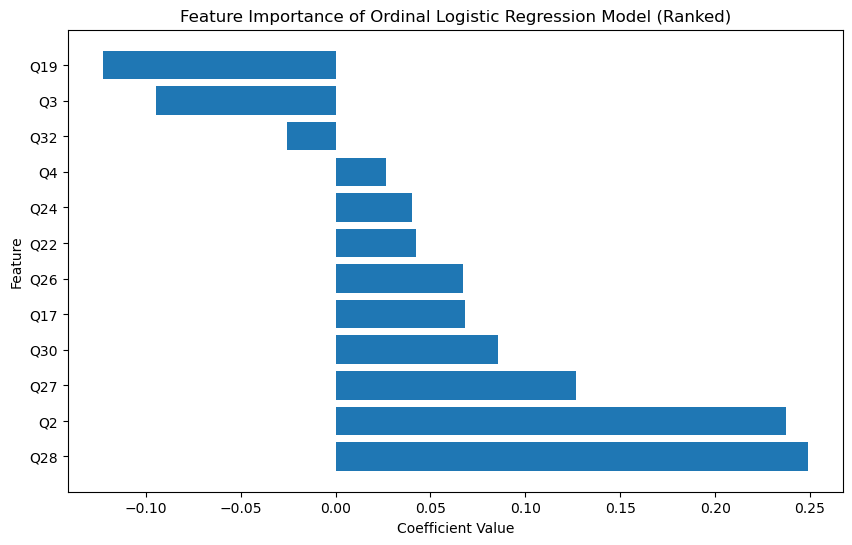

In [183]:
# Get the coefficients and feature names
coefficients = model.coef_
feature_names = train_df_selected.columns

# Get the indices that would sort the coefficients in descending order
sorted_indices = np.argsort(coefficients[0])[::-1]

# Sort the coefficients and feature names based on the sorted indices
sorted_coefficients = coefficients[0, sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(np.arange(len(sorted_feature_names)), sorted_coefficients, align='center')
plt.yticks(np.arange(len(sorted_feature_names)), sorted_feature_names)
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importance of Ordinal Logistic Regression Model (Ranked)')
plt.show()


# Question 5: Testing

In [184]:
#TODO: Using the best-performing model, evaluate the model performance both on the training set and test set

#TODO: set the best-performing hyperparameters identified via grid search
model_test = best_model.fit(X_train, y_train)

y_pred_test = model_test.predict(X_test)


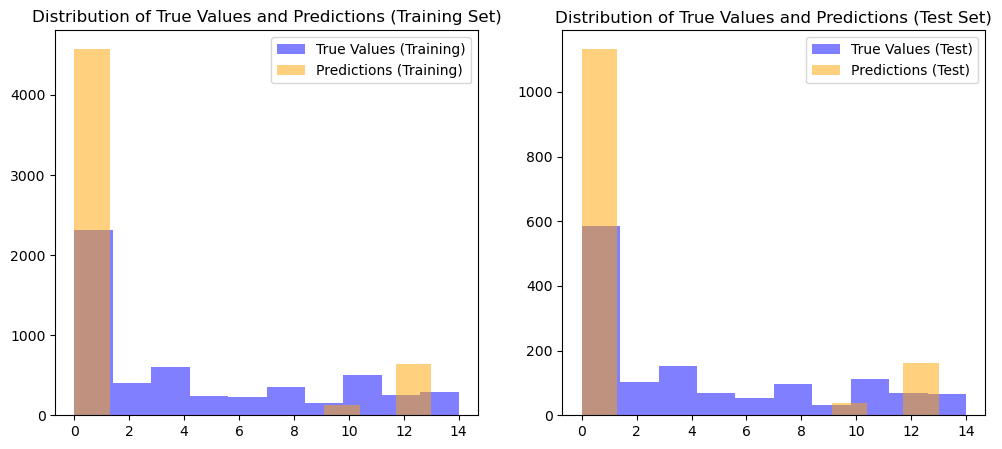

In [185]:

# TODO: Print classification report and confusion matrix for the test set

# Plot the distribution of true target variable values and predictions for both training and test sets
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Plot for Training Set
axes[0].hist(y_train, color='blue', alpha=0.5, label='True Values (Training)')
axes[0].hist(best_model.predict(X_train), color='orange', alpha=0.5, label='Predictions (Training)')
axes[0].set_title('Distribution of True Values and Predictions (Training Set)')
axes[0].legend()

# Plot for Test Set
axes[1].hist(y_test, color='blue', alpha=0.5, label='True Values (Test)')
axes[1].hist(y_pred_test, color='orange', alpha=0.5, label='Predictions (Test)')
axes[1].set_title('Distribution of True Values and Predictions (Test Set)')
axes[1].legend()

plt.show()